# "Анализ бизнес-показателей сервиса "Яндекс.Афиша"<a class="tocSkip">

## Цель исследования

<div style="border: ridge black 3px; padding: 25px">
    
<b> Целью данного исследования является определение наиболее перспективных рекламных источников трафика с целью последующего перераспределения бюджета и снижения маркетинговых расходов сервиса "Яндекс.Афиша" на привлечение клиентов.</b><br><br>
    
Мы изучим основные пользовательские метрики (на основе данных 3-х предоставленных датафреймов): продуктовые метрики, метрики электронной коммерции и маркетинговые метрики.<br><br>
        
Мы произведем необходимую предобработку данных, рассчитаем метрики и в конце исследования сформулируем общий вывод.
    
</div>

## Описание исходных данных
**Ниже представлено описание всей доступной нам информации по трём представленным датафреймам.**

Файл `visits_log.csv` хранит лог сервера с информацией о посещениях сайта, 
файл `orders_log.csv` — информацию о заказах,
файл `costs.csv` — информацию о расходах на маркетинг. 
Данные представлены за период: с Июня 2017 по конец Мая 2018 года.

Пути к файлам:

1) Визиты: */datasets/visits_log.csv*

2) Заказы: */datasets/orders_log.csv*

3) Расходы: */datasets/costs.csv*

---

Структура `visits_log.csv`:

- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

Структура `orders_log.csv`:

- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа (измеряется в условных единицах — у.е.).

Структура `costs.csv`:

- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

## Открытие данных

In [1]:
# импортируем основные нужные библиотеки для будущих манипуляций

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sb
sb.set_style("whitegrid")
from matplotlib import pyplot as plt

In [2]:
# присвоим каждому (из 3-х) датафрейму одноименные названия переменных

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Из исходных данных сразу видно, что присутствует разный регистр у названий столбцов и пробелы в названиях. Приведем все названия столбцов к единому регистру и переименуем методом `.rename()`некоторые из столбцов для удобства понимания в дальнейших манипуляциях.

In [3]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

visits = visits.rename({'start ts': 'session_start', 'end ts': 'session_end', 'source id': 'source_id'}, axis = 'columns')
orders = orders.rename({'buy ts': 'order_date_time'}, axis = 'columns')
costs = costs.rename({'dt': 'ad_date_time'}, axis = 'columns')

In [4]:
# используя цикл, посмотрим сразу на общую информацию по каждой таблице и выведем на экран содержимое 
# первых 10 строк, а также градиентом наличие/отсутствие пропусков:

visits.name = 'Таблица "Информация о посещениях сайта"'    # дадим названия каждой из таблиц для удобства просмотра
orders.name = 'Таблица "Информация о заказах"'
costs.name = 'Таблица "Информация о расходах на маркетинг"'


for data in [visits, orders, costs]:
    print(data.name)
    print('--------------------------------------------------------------------------------------------------------------')
    print(data.info())
    display(data.head(10))
    print('Кол-во пропусков')
    display(pd.DataFrame((data.isna().mean()*100).round(2)).style.background_gradient('coolwarm'))
    print('--------------------------------------------------------------------------------------------------------------')
    print()                                                        

Таблица "Информация о посещениях сайта"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
session_end      359400 non-null object
source_id        359400 non-null int64
session_start    359400 non-null object
uid              359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,device,session_end,source_id,session_start,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Кол-во пропусков


,0
device,0
session_end,0
source_id,0
session_start,0
uid,0


--------------------------------------------------------------------------------------------------------------

Таблица "Информация о заказах"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date_time    50415 non-null object
revenue            50415 non-null float64
uid                50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


,order_date_time,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Кол-во пропусков


,0
order_date_time,0
revenue,0
uid,0


--------------------------------------------------------------------------------------------------------------

Таблица "Информация о расходах на маркетинг"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id       2542 non-null int64
ad_date_time    2542 non-null object
costs           2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


,source_id,ad_date_time,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Кол-во пропусков


,0
source_id,0
ad_date_time,0
costs,0


--------------------------------------------------------------------------------------------------------------



### Вывод

<div style="border:solid black 2px; padding: 20px">
    
При открытии данных мы скорректировали названия столбцов, привели их к нижнему единому регистру.
Все 3 датафрейма пропусков не имеют.<br><br>
При чтении общей информации по каждому из 3-х датафреймов мы обнаружили следующие моменты, требующие коррекции:<br>
- Датафрейм <b>`visits`</b>: столбцы `session_start`, `session_end` необходимо перевести из типа <i>object</i> в тип <i>datetime</i>.<br>
- Датафрейм <b>`orders`</b>: столбец `order_date_time` необходимо перевести из типа  <i>object</i> в тип <i>datetime</i>.<br>
- Датафрейм <b>`costs`</b>: столбец `ad_date_time` необходимо перевести из типа <i>object</i> в тип <i>datetime</i>.<br><br>
    
Далее приступим к изменению типов данных.<br>
</div>

## Предобработка данных

### Изменение типов данных

Как было сказано в выводе выше выполняем изменение типов данных и проверим на выходе результат, отобразив общую информацию.

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%Y-%m-%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'], format = '%Y-%m-%d %H:%M:%S')
orders['order_date_time'] = pd.to_datetime(orders['order_date_time'], format = '%Y-%m-%d %H:%M:%S')
costs['ad_date_time'] = pd.to_datetime(costs['ad_date_time'], format = '%Y-%m-%d')

for data in [visits, orders, costs]:
    print('--------------------------------------------------------------------------------------------------------------')
    print(data.name)
    print('--------------------------------------------------------------------------------------------------------------')
    print(data.info())

--------------------------------------------------------------------------------------------------------------
Таблица "Информация о посещениях сайта"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
session_end      359400 non-null datetime64[ns]
source_id        359400 non-null int64
session_start    359400 non-null datetime64[ns]
uid              359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None
--------------------------------------------------------------------------------------------------------------
Таблица "Информация о заказах"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 5041

Изменение типов данных выполнили, проверим наличие грубых дубликатов в датафреймах.

In [6]:
# с помощью цикла выполним проверку по всем таблицам

for data in [visits, orders, costs]:
    duplicated_found = data.duplicated().sum()
    if duplicated_found > 0:
        print('Количество дубликатов в {} = '.format(data.columns.values), end='')
        print(duplicated_found)
    else:
        print('Дубликатов в {} не найдено'.format(data.columns.values))

Дубликатов в ['device' 'session_end' 'source_id' 'session_start' 'uid'] не найдено
Дубликатов в ['order_date_time' 'revenue' 'uid'] не найдено
Дубликатов в ['source_id' 'ad_date_time' 'costs'] не найдено


### Вывод

<div style="border:solid black 2px; padding: 20px">
    
Мы выполнили необходимую предобработку данных: скорректировали типы данных, проверили наличие дубликатов.
Можем приступить к расчёту метрик и их анализу.

</div>

## Расчёт метрик

### Продуктовые метрики

#### DAU, WAU, MAU

**Рассчитаем DAU, WAU и MAU и визуально на графиках отобразим результат изменения данных метрик во времени за период с Июня 2017 по конец Мая 2018 года**.

In [7]:
# проверим точные даты первого и последнего дня наблюдений столбца 'session_start'
visits['session_start'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: session_start, dtype: object

Как и указано в исходных данных, мы имеем данные с визитами пользователей за период: **с 01 Июня 2017 по 31 Мая 2018**.

In [8]:
# создадим отдельные столбцы с номерами года, месяца, недели и полной датой начала сессии

visits['session_year_n']  = visits['session_start'].dt.year
visits['session_month_n'] = visits['session_start'].dt.month
visits['session_week_n']  = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

# группируем данные по нужным столбцам для определенных метрик DAU, WAU, MAU, соответственно, подсчитаем число
# уникальных пользователей и найдём их средние значения 

dau = int(visits.groupby('session_date').agg({'uid': 'nunique'}).mean())
wau = int(visits.groupby(['session_year_n', 'session_week_n']).agg({'uid': 'nunique'}).mean())
mau = int(visits.groupby(['session_year_n','session_month_n']).agg({'uid': 'nunique'}).mean())

print('За период с 01 Июня 2017 по 31 Мая 2018:')
print()
print('Среднее значение DAU (daily active users) = {}'.format(dau))
print('Среднее значение WAU (weekly active users) = {}'.format(wau))
print('Среднее значение MAU (monthly active users) = {}'.format(mau))

За период с 01 Июня 2017 по 31 Мая 2018:

Среднее значение DAU (daily active users) = 907
Среднее значение WAU (weekly active users) = 5716
Среднее значение MAU (monthly active users) = 23228


Построим графики, показывающие динамику изменения метрик DAU, WAU, MAU за период с 01 Июня 2017 по 31 Мая 2018.

In [9]:
# для графиков создадим наиболее полные столбцы `session_month` и `session_week`

visits['session_month'] = visits['session_start'].astype('datetime64[M]')
visits['session_week']  = visits['session_start'].astype('datetime64[W]')

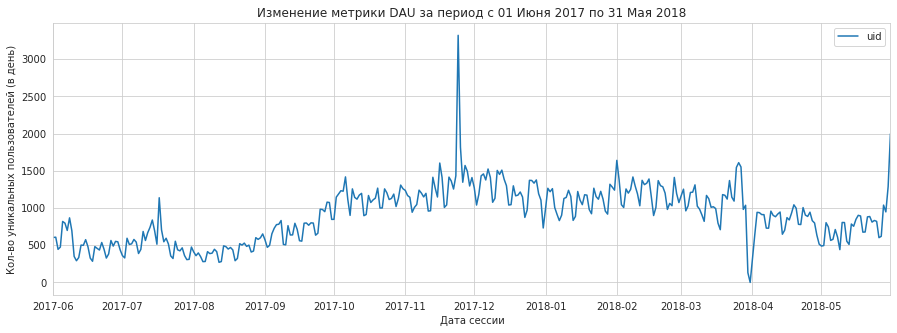

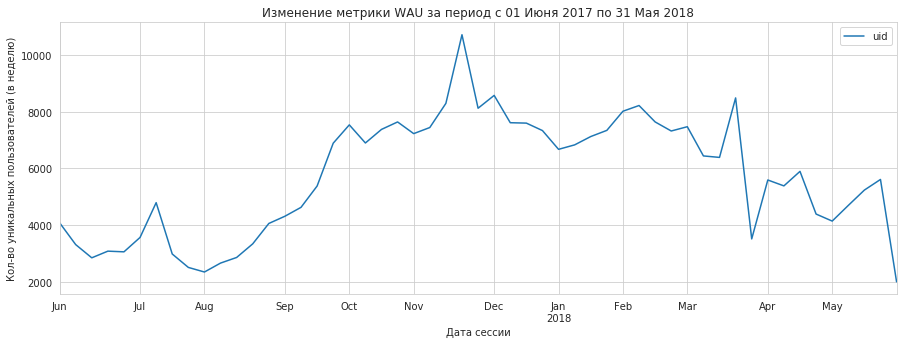

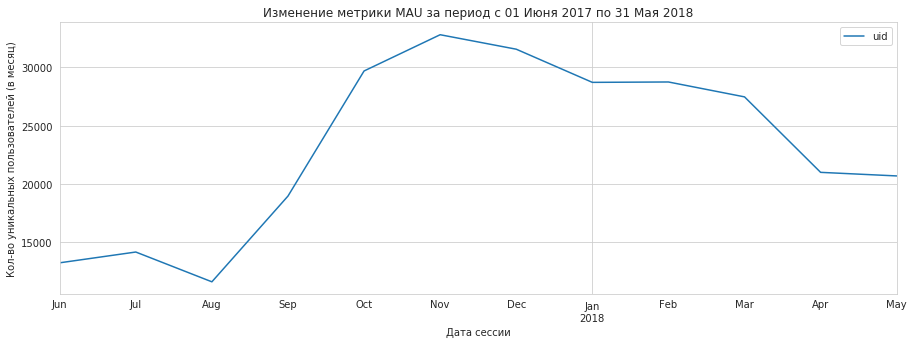

In [10]:
# строим 3 графика 

# для метрики DAU
visits.groupby('session_date').agg({'uid':'nunique'}).plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата сессии')
plt.ylabel('Кол-во уникальных пользователей (в день)')
plt.title('Изменение метрики DAU за период с 01 Июня 2017 по 31 Мая 2018')
plt.show()

# для метрики WAU
visits.groupby('session_week').agg({'uid':'nunique'}).plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата сессии')
plt.ylabel('Кол-во уникальных пользователей (в неделю)')
plt.title('Изменение метрики WAU за период с 01 Июня 2017 по 31 Мая 2018')
plt.show()

# для метрики MAU
visits.groupby('session_month').agg({'uid':'nunique'}).plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата сессии')
plt.ylabel('Кол-во уникальных пользователей (в месяц)')
plt.title('Изменение метрики MAU за период с 01 Июня 2017 по 31 Мая 2018')
plt.show()

<b>Из данных графиков видно, что:</b><br><br>

<b>1)</b> DAU: К концу Ноября 2017 произошел скачок метрики DAU. В конце Марта 2018 - резкий спад метрики DAU.<br><br>
    
<b>2)</b> WAU: динамика изменения по сравнению с DAU сглажена. Прослеживаются те же пиковые зоны как у DAU.<br><br>
 
<b>3)</b> MAU: На графике метрики MAU изменение динамики  не так явно просматривается, мы видим явную точку начала роста кол-ва пользователей в месяц: конец Июля 2017 - начало Августа 2017. И с Апреля 2018 начинается спад MAU.<br>

<b>Замеченные тенденции:</b><br><br>

По графику WAU можно заметить хорошую посещаемость сервиса в осенне-зимний период (с Октября 2017 по Февраль 2018), показатели держатся на высоких уровнях в сравнении со всем остальным периодом. И, наоборот, в весенние и летние месяцы посещаемость сервиса ниже.<br>
<hr>
Исследуем подробнее пиковые точки: пик посещаемости - конец Ноября 2017 г. и падение посещаемости - в конце Марта 2018 г.<br><br>

Выведем детализированную разбивку по дням, чтобы рассмотреть конкретные и близлежащие дни к этим точкам. На основании этих дней можно провести доп.исследование (но нужны будут новые данные) были ли в эти дни скидки, акции, какие именно, если были, или, наоборот, может на сервисе было очень мало предложений от организаторов концертов/мероприятий.<br><br>

С имеющимися у нас данными мы можем проверить были ли в эти дни расходы на маркетинг и как это повлияло на обнаруженные пиковые дни.

In [11]:
# проверим конец Ноября 2017
visits_in_nov17 = visits.query('session_start >= "2017-11-20 00:00:00" and session_start < "2017-12-01 00:00:00"') \
.groupby('session_date').agg({'uid':'nunique'}).reset_index()
visits_in_nov17.columns = ['Дата сессии', 'Кол-во уникальных пользователей']

# и проверим расходы в конце Ноября 2017
costs_in_nov17 = costs.query('ad_date_time >= "2017-11-20 00:00:00" and ad_date_time < "2017-12-01 00:00:00"') \
.groupby('ad_date_time').agg({'costs':'sum'}).reset_index()
costs_in_nov17.columns = ['Дата', 'Сумма расходов (у.е.)']

print()
print('DAU (период 2017-11-20 - 2017-11-30)')
display(pd.DataFrame(visits_in_nov17).style.background_gradient('coolwarm'))
print()
print('Расходы на маркетинг (период 2017-11-20 - 2017-11-30)')
display(pd.DataFrame(costs_in_nov17).style.background_gradient('coolwarm'))
print('___________________________________________________________________________________________________________________')

# и проверим конец Марта 2018 (+ начало Апреля)
visits_in_mar18 = visits.query('session_start >= "2018-03-20 00:00:00" and session_start < "2018-04-07 00:00:00"') \
.groupby('session_date').agg({'uid':'nunique'}).reset_index()
visits_in_mar18.columns = ['Дата сессии', 'Кол-во уникальных пользователей']

# и расходы в конце Марта 2018 (+ начало Апреля)
costs_in_mar18 = costs.query('ad_date_time >= "2018-03-20 00:00:00" and ad_date_time < "2018-04-07 00:00:00"') \
.groupby('ad_date_time').agg({'costs':'sum'}).reset_index()
costs_in_mar18.columns = ['Дата', 'Сумма расходов (у.е.)']

print()
print('DAU (период 2018-03-20 - 2018-04-06)')
display(pd.DataFrame(visits_in_mar18).style.background_gradient('coolwarm'))
print()
print('Расходы на маркетинг (период 2018-03-20 - 2018-04-06)')
display(pd.DataFrame(costs_in_mar18).style.background_gradient('coolwarm'))


DAU (период 2017-11-20 - 2017-11-30)


,Дата сессии,Кол-во уникальных пользователей
0,2017-11-20,1415
1,2017-11-21,1363
2,2017-11-22,1255
3,2017-11-23,1433
4,2017-11-24,3319
5,2017-11-25,1817
6,2017-11-26,1346
7,2017-11-27,1571
8,2017-11-28,1493
9,2017-11-29,1296



Расходы на маркетинг (период 2017-11-20 - 2017-11-30)


,Дата,Сумма расходов (у.е.)
0,2017-11-20 00:00:00,660.41
1,2017-11-21 00:00:00,1196.85
2,2017-11-22 00:00:00,1145.03
3,2017-11-23 00:00:00,1300.34
4,2017-11-24 00:00:00,3458.86
5,2017-11-25 00:00:00,1747.36
6,2017-11-26 00:00:00,1047.25
7,2017-11-27 00:00:00,1432.92
8,2017-11-28 00:00:00,1333.76
9,2017-11-29 00:00:00,1269.89


___________________________________________________________________________________________________________________

DAU (период 2018-03-20 - 2018-04-06)


,Дата сессии,Кол-во уникальных пользователей
0,2018-03-20,1171
1,2018-03-21,1120
2,2018-03-22,1369
3,2018-03-23,1146
4,2018-03-24,1093
5,2018-03-25,1545
6,2018-03-26,1609
7,2018-03-27,1551
8,2018-03-28,981
9,2018-03-29,1037



Расходы на маркетинг (период 2018-03-20 - 2018-04-06)


,Дата,Сумма расходов (у.е.)
0,2018-03-20 00:00:00,1285.84
1,2018-03-21 00:00:00,710.56
2,2018-03-22 00:00:00,1407.32
3,2018-03-23 00:00:00,1061.5
4,2018-03-24 00:00:00,942.07
5,2018-03-25 00:00:00,841.25
6,2018-03-26 00:00:00,1527.16
7,2018-03-27 00:00:00,1205.54
8,2018-03-28 00:00:00,927.8
9,2018-03-29 00:00:00,1039.45


Видим, что 24 ноября 2017 (Пятн.)  - день, в который на сервис Яндекс.Афиши зашло пиковое число посетителей в сравнении со всем годом (3319 чел за день). И в этот же день было израсходовано 3458.86 у.е. на маркетинг, что сильно выделяется из всех остальных дней. Скорее всего именно в этот день Яндекс.Афишей проводилась Черная Пятница и активные маркетинговые мероприятия, которые и привлекли пользователей.

И, наоборот, 31 Марта 2018 был всего 1 уникальный посетитель и именно в этот день было 0.7 у.е. расходов на маркетинг, что похоже на техническую ошибку сбора записи или в действительности же в этот день сервис был по тех.причинам недоступен (возможно велись определенные запланированные технические работы). Также удивительно, что 1 Апреля 2018 отсутствует в обоих таблицах: возможно команда Яндекс.Афиши уже 31 Марта 2018 начала проводить какие-то технические работы и продолжила это делать 1 Апреля, воспользовавшись этим как шуткой в честь 1-апрельского Дня смеха, но в своих производственных целях.

#### Среднее кол-во посещений сайта (в день)

**Определим сколько раз за день пользователи в среднем заходят на сайт.**

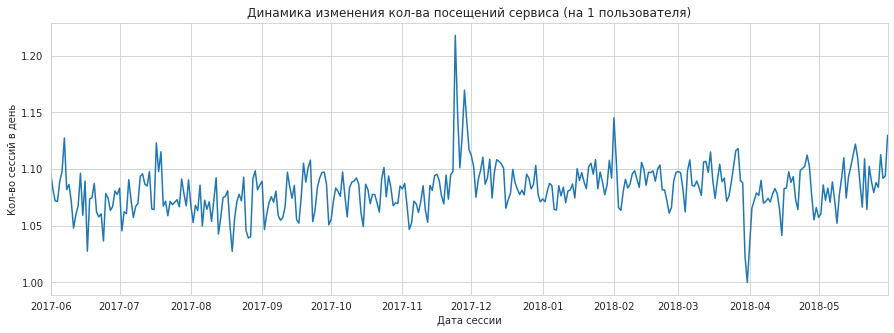

In [12]:
sessions_per_day = visits.groupby('session_date').agg({'uid': ['count', 'nunique']})
sessions_per_day.columns = ['n_sessions', 'n_users']

# найдем среднее число сессий в день на 1 пользователя
sessions_per_day['sessions_per_user'] = sessions_per_day['n_sessions'] / sessions_per_day['n_users']

# построим график распределения 'sessions_per_user' по датам
ax = sessions_per_day['sessions_per_user'].plot(grid=True, figsize=(15, 5))
ax.set_xlabel('Дата сессии')
ax.set_ylabel('Кол-во сессий в день')
ax.set_title('Динамика изменения кол-ва посещений сервиса (на 1 пользователя)')
plt.show()

Мы видим те же самые точки пика и падения, что и при изучении кол-ва уникальных пользователей в день/неделю. Но даже в точку пика 24 Ноября 2017 в среднем 1 пользователь не заходил на сайт больше 1 раза.

In [13]:
mean_sessions_per_day = sessions_per_day['n_sessions'].sum() / sessions_per_day['n_users'].sum()
display(sessions_per_day.head())
print('В среднем в день 1 пользователь заходит на сайт: {} раз'.format(mean_sessions_per_day))

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


В среднем в день 1 пользователь заходит на сайт: 1.0874136559064957 раз


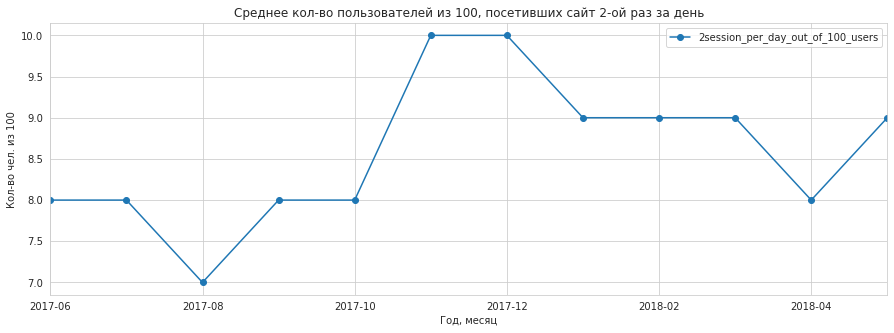

In [14]:
# рассчитаем сколько человек из 100 совершают повторный заход на сайт в день

sessions_per_day = sessions_per_day.reset_index()
sessions_per_day['2session_per_day_out_of_100_users'] = (sessions_per_day['sessions_per_user'] - 1) * 100

sessions_per_day['session_date'] = pd.to_datetime(sessions_per_day['session_date'], format = '%Y-%m-%d')
sessions_per_day['session_month'] = sessions_per_day['session_date'].dt.strftime('%Y-%m') 

# сгруппируем по месяцу и найдем среднее значение кол-ва пользователей, зашедших дважды на сайт из 100 чел.

mean_users_out_of_100_users_per_m = sessions_per_day.groupby('session_month').agg({'2session_per_day_out_of_100_users': 'mean'}) \
.apply(np.ceil)


mean_users_out_of_100_users_per_m.plot(style='o-', grid=True, figsize=(15, 5))
plt.xlabel('Год, месяц')
plt.ylabel('Кол-во чел. из 100')
plt.title('Среднее кол-во пользователей из 100, посетивших сайт 2-ой раз за день')
plt.show()

Максимальный показатель - это 10 человек из 100 посещали дважды сайт в Ноябре 2017 и Декабре 2017.

И минимальный -  7 человек из 100 в Августе 2017.

#### Средняя продолжительность сессии на сайте

**Определим сколько в среднем длится сессия пользователя за весь период - рассчитаем ASL (average session length). И для выбора подходящей средней меры построим гистограмму распределения.**

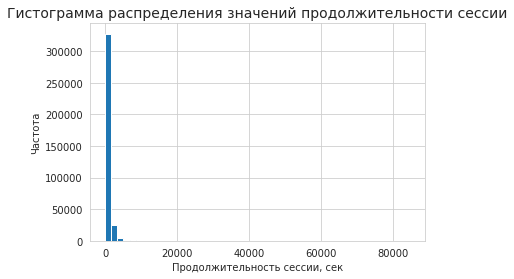

In [15]:
# вычитаем из даты окончания сесии дату начала сессии (результат переводим в секунды)

visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits['session_duration_sec'].hist(bins=50)
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений продолжительности сессии', fontsize=14)
plt.show()

Распределение **не** близко к нормальному, поэтому в качестве средней меры рассчитаем моду (значение, которое встречается чаще всего).

In [16]:
mode_session = visits['session_duration_sec'].mode()
print('Продолжительность типичной пользовательской сессии за период с 01 Июня 2017 по 31 Мая 2018  = {}' \
      .format(mode_session.to_list()), 'секунд.')

Продолжительность типичной пользовательской сессии за период с 01 Июня 2017 по 31 Мая 2018  = [60] секунд.


#### Retention Rate посещений пользователей. Когортный анализ Retention Rate

**Для анализа оттока клиентов применим когортный анализ и рассчитаем Retention Rate относительно посещений пользователей, а также отобразим на графике изменение во времени метрики Retention Rate. Когорты разобьём по месяцам, т.к данные представлены за 12 месяцев (более детальный анализ по неделям не используем, т.к. он применим к более узкому периоду изучения, чем год).**

In [17]:
# для каждого пользователя найдем дату его первого захода на сайт (дата начала сессии, столбец `session_date`)
first_activity_date = visits.groupby('uid')['session_date'].min() 
first_activity_date.name = 'first_activity_date'  # переименуем столбец 'session_date'

# присоединим к датафрейму `visits` дату первого захода по столбцу `uid` 
visits = visits.join(first_activity_date, on='uid')

# выделим теперь месяцы из столбцов `session_start`, `first_activity_date`
visits['activity_month'] = visits['session_start'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

Когортой будет являться столбец `'first_activity_month'` (месяц, в который пользователь впервые зашел на сайт). Рассчитаем теперь *`lifetime`* пользователя (создадим столбец `'cohort_lifetime'` как разницу между `'activity_month'` и `'first_activity_month'`).

In [18]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']

# приведем его к кол-ву месяцев, разделив на константу 
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')

# cгруппируем данные по когорте и lifetime
# подсчитаем для каждой когорты количество уникальных пользователей
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

# найдём исходное количество пользователей в когорте; возьмём их число на "нулевой" месяц lifetime
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# объединим `cohorts` с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

# и теперь рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

# оставим в столбце `first_activity_month` только год и месяц
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m') 

Построим сводную таблицу и создадим тепловую карту с Retention Rate.

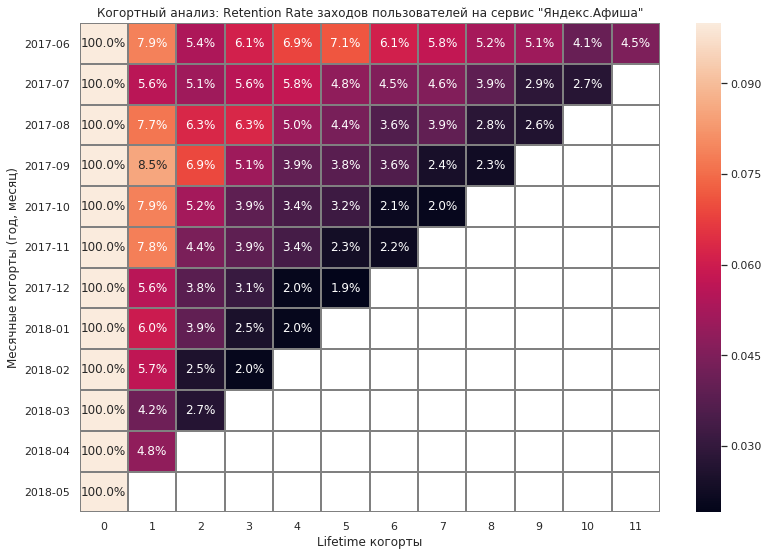

In [19]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когортный анализ: Retention Rate заходов пользователей на сервис "Яндекс.Афиша"')
sns.heatmap(retention_pivot, vmax=0.1, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.ylabel('Месячные когорты (год, месяц)')
plt.xlabel('Lifetime когорты')
plt.show()

In [20]:
# 1-ый месяц жизни когорт считается нулевым с 100% Retention Rate,
# поэтому 2-ой месяц жизни равен 1 в столбце `cohort_lifetime` - по нему и сделаем срез со столбцом `retention`

retention_2month = cohorts[cohorts['cohort_lifetime'] == 1][['retention']]
mean_retention_2month = (retention_2month['retention'].mean() * 100).round(2) 

print('Средний Retention Rate на 2-ой месяц жизни когорт = {} %'.format(mean_retention_2month))

Средний Retention Rate на 2-ой месяц жизни когорт = 6.52 %


#### Вывод

<div style="border:solid black 2px; padding: 20px">
    
**На основании произведенных расчетов продуктовых метрик обнаружено следующее:**   
    
1) При анализе метрики DAU обнаружен пиковый период по кол-ву активных пользователей в день: конец Ноября 2017 г. Возможно, сказывается сезонность (приближение новогодних праздников). Период сильного спада показателя DAU - конец марта 2018 г.
    
2) По метрике MAU наглядно видно, что в конце Июля 2017 г. были самые низкие показатели MAU, после чего уже с Августа 2017 наблюдается рост MAU до конца изучаемого периода.
    
3) В среднем в день пользователи заходят на сайт 1 раз.
    
4) Продолжительность типичной пользовательской сессии (за период с 01 Июня 2017 по 31 Мая 2018)  равна 60 секундам.
    
5) Retention Rate относительно заходов пользователей при когортном анализе показал падение показателей с каждым новым месяцем жизни в каждой из рассматриваемых месячных когорт (за период с 01 Июня 2017 по 31 Мая 2018). Средний Retention Rate на 2-ой месяц жизни когорт = 6.52 %
   
 
</div>

### Метрики электронной коммерции

#### Среднее время с момента первого посещения до совершения первой покупки

**Определим сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.**

In [21]:
# найдём время первого захода на сайт каждого пользователя
first_sessions_dt = visits.groupby(['uid']).agg({'session_start':'min'})
first_sessions_dt.columns = ['first_sessions_dt']

# найдем время первой покупки каждого пользователя
first_orders_dt = orders.groupby(['uid']).agg({'order_date_time':'min'})
first_orders_dt.columns = ['first_orders_dt']

# объединим вместе полученные результаты (по 'uid') 
first_orders_dt = first_orders_dt.join(first_sessions_dt, on='uid')

# рассчитаем в минутах время, которое прошло с момента первого захода на сайт до первой покупки
first_orders_dt['time_to_first_order'] = \
(first_orders_dt['first_orders_dt'] - first_orders_dt['first_sessions_dt']) / np.timedelta64(1, 'm')

Посмотрим на распределение `time_to_first_order` на гистограмме.

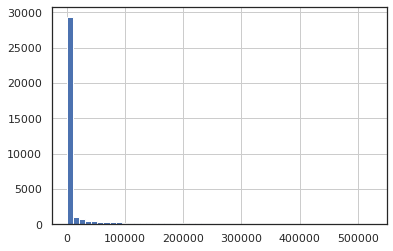

In [22]:
first_orders_dt['time_to_first_order'].hist(bins=50)
plt.show()

Распределение **не** является нормальным, поэтому для определения среднего времени с момента первого посещения сайта до совершения покупки рассчитаем моду.

In [23]:
print('Среднее время с момента первого посещения сайта до первой покупки = {} минута' \
      .format(int(first_orders_dt['time_to_first_order'].mode())))

Среднее время с момента первого посещения сайта до первой покупки = 1 минута


По данной цифре в 1 минуту можно сказать, что пользователи чаще всего целенаправленно заходят на сайт именно за оформлением покупки.

#### Cреднее количество покупок на 1 покупателя за 6 месяцев

**Рассчитаем среднее количество покупок на 1 покупателя за период в 6 месяцев: с Июня 2017 до Ноября 2017.**

In [24]:
import warnings
warnings.filterwarnings('ignore')

# создадим срез: выберем нужный нам период до конца Ноября 2017 и с суммой заказа > 0
orders_jun17_nov17 = orders.query('order_date_time < "2017-12-01 00:00:00" and revenue > 0')

# в полученном срезе создадим столбец с месяцем заказа
orders_jun17_nov17['order_month'] = orders['order_date_time'].astype('datetime64[M]')

# группируем по месяцу заказа и считаем общее кол-во заказов и кол-во уникальных покупателей 
orders_grouped_by_user = orders_jun17_nov17.groupby('order_month').agg({'uid': ['count', 'nunique']})
orders_grouped_by_user.columns = ['n_orders', 'n_users']

# создадим столбец с рассчитанным кол-вом покупок на 1 покупателя (в каждом из 6 месяцев, соответственно)
orders_grouped_by_user['orders_per_user'] = orders_grouped_by_user['n_orders'] / orders_grouped_by_user['n_users']

# выведем на экран результат и рассчитанное среднее кол-во покупок на 1 покупателя за исследуемый период
display(orders_grouped_by_user)
print('Cреднее количество покупок на 1 покупателя (за период с Июня 2017 до Ноября 2017) =', \
      orders_grouped_by_user['orders_per_user'].mean().round(3))

,n_orders,n_users,orders_per_user
order_month,,,
2017-06-01,2353,2022,1.163699
2017-07-01,2362,1983,1.191125
2017-08-01,1803,1471,1.225697
2017-09-01,3383,2748,1.231077
2017-10-01,5677,4673,1.214851
2017-11-01,5644,4543,1.242351


Cреднее количество покупок на 1 покупателя (за период с Июня 2017 до Ноября 2017) = 1.211


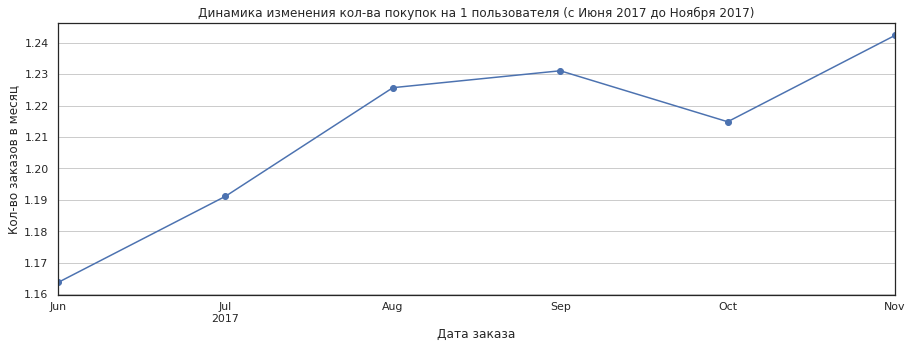

In [25]:
# построим график с динамикой изменения 'orders_per_user' по месяцам

ax = orders_grouped_by_user['orders_per_user'].plot(style='o-', grid=True, figsize=(15, 5))
ax.set_xlabel('Дата заказа')
ax.set_ylabel('Кол-во заказов в месяц')
ax.set_title('Динамика изменения кол-ва покупок на 1 пользователя (с Июня 2017 до Ноября 2017)')
plt.show()

По данному графику видно, что минимальные и максимальные значения показателя кол-ва покупок в месяц на 1 покупателя не значительно отличаются: **1,16** в Июне 2017 и **1,24** в Ноябре 2017. 

Но, в среднем больше всего покупок было сделано именно в Ноябре 2017 (когда проводилась Черная Пятница, к тому же осенне-зимний период имеет позитивную тенденцию по наибольшему кол-ву посещений сервиса). Летние месяцы Июнь и Июль имеют меньшие показатели, что соответствует и меньшему кол-ву сессий на сайте в это время.

#### Средний чек

**Рассчитаем средний чек, применяя группировку по времени совершения покупки.**
Bизуально на графике отобразим результат изменения метрики во времени. Для расчета возьмем период в 6 месяцев и воспользуемся уже созданным срезом `orders_jun17_nov17` (период с начала Июня 2017 до конца Ноября 2017 и с суммой покупок > 0).

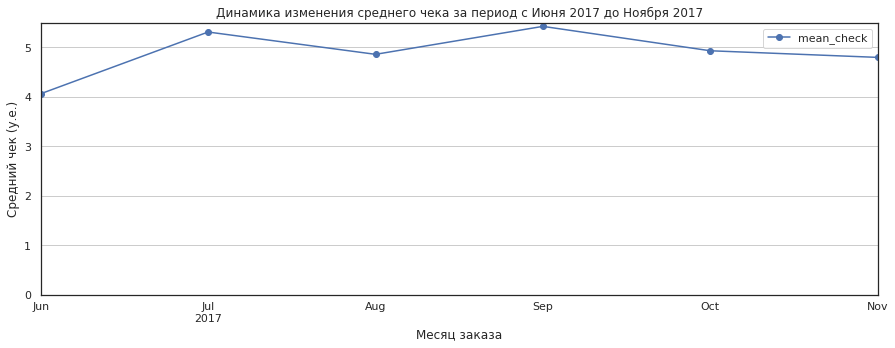

,order_month,n_orders,total_revenue,mean_check
0,2017-06-01,2353,9557.49,4.061832
1,2017-07-01,2362,12539.47,5.308836
2,2017-08-01,1803,8758.78,4.857892
3,2017-09-01,3383,18345.51,5.422852
4,2017-10-01,5677,27987.70,4.930016
5,2017-11-01,5644,27069.93,4.796231


Cредний чек (за период с Июня 2017 до Ноября 2017) = 4.9 у.е.


In [26]:
# также сгруппируем по времени создания заказа (по месяцу) и подсчитаем общее кол-во заказов и сумму выручкb
mean_check_jun17_nov17 = orders_jun17_nov17.groupby('order_month').agg({'uid': 'count', 'revenue': 'sum'}).reset_index()
mean_check_jun17_nov17.columns = ['order_month', 'n_orders', 'total_revenue']

# создадим столбец с рассчитанным средним чеком (в каждом из 6 месяцев, соответственно)
mean_check_jun17_nov17['mean_check'] = mean_check_jun17_nov17['total_revenue'] / mean_check_jun17_nov17['n_orders']

# строим график
mean_check_jun17_nov17.plot(grid=True, figsize=(15, 5), style='o-', x='order_month', y='mean_check')
plt.xlabel('Месяц заказа')
plt.ylabel('Средний чек (у.е.)')
plt.title('Динамика изменения среднего чека за период с Июня 2017 до Ноября 2017')
plt.ylim(0)
plt.show()

# выведем на экран результат и рассчитанный средний чек за исследуемый период
display(mean_check_jun17_nov17)
print('Cредний чек (за период с Июня 2017 до Ноября 2017) = {} у.е.' \
      .format(mean_check_jun17_nov17['mean_check'].mean().round(2)))

Из данного графика и изучаемого периода видим, что за падением следует повышение и, наоборот. Волнообразное изменение среднего чека за 6 месяцев. Июль 2017 и Сентябрь 2017 - пиковые месяцы. 

#### LTV

**Рассчитаем LTV по когортам**, и LTV по когортам, "прожившим" не менее 6 месяцев при известной нам маржинальности сервиса в 100%. На графике визуализируем изменение LTV во времени.

In [27]:
# проверим распределение дат заказов и дат расходов

display(orders['order_date_time'].describe())
print('-----------------------------')
display(costs['ad_date_time'].describe())

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: order_date_time, dtype: object

-----------------------------


count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: ad_date_time, dtype: object

Диапазон дат заказов и дат расходов отличается только на 1 день: 1 Июня 2018 не будем учитывать, возьмем данные таблицы `orders`только по 31 Мая 2018 вкл.

In [28]:
orders = orders.query('order_date_time <= "2018-05-31 00:00:00"')

# выделим месяцы из дат в таблицах с заказами и расходами
orders['order_month'] = orders['order_date_time'].astype('datetime64[M]')
costs['ad_month'] = costs['ad_date_time'].astype('datetime64[M]')

# найдем месяц первого заказа каждого покупателя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# посчитаем кол-во уникальных покупателей за каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = pd.merge(orders, first_orders, on='uid')

# сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

# добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

Поскольку маржинальность равна 100%, то для расчета LTV нет необходимости считать валовую прибыль, т.к. она равна выручке (скопируем её).
Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем LTV когорт с помощью тепловой карты на основе результирующей сводной таблицы.

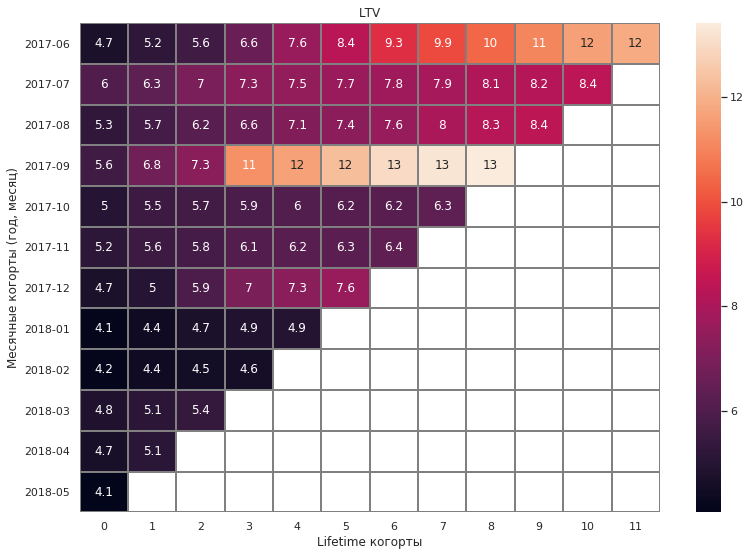

In [29]:
report['gross_profit'] = report['revenue'].copy()

# создаем столбец с "возрастом" когорты в месяцах
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

# считаем  ltv
report['ltv'] = report['gross_profit'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')  # оставляем для удобства только год и месяц

# строим сводную таблицу и тепловую карту
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
ltv = output.cumsum(axis=1)
ltv.fillna('') 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(ltv, annot=True, linewidths=1, linecolor='gray')
plt.ylabel('Месячные когорты (год, месяц)')
plt.xlabel('Lifetime когорты')
plt.show()

Найдём накопительный средний LTV за 6 месяцев.

In [30]:
# используем сводную таблицу `output` и применим метод `cumsum` к 6 месяцу "жизни" когорт

mean_6m_ltv = output.cumsum(axis=1).mean(axis=0)[5] 
print('Средний LTV за 6 месяцев = {} у.е.'.format(mean_6m_ltv.round(1)))

Средний LTV за 6 месяцев = 8.0 у.е.


#### Вывод

<div style="border:solid black 2px; padding: 20px">
    
<b>На основании произведенных расчетов метрик электронной коммерции обнаружено следующее:</b><br><br>
    
За период с Июня 2017 до Ноября 2017:<br><br>
    
1) Среднее время с момента первого посещения сайта до первой покупки равно 1 минуте.<br>
    
2) Cреднее количество покупок на 1 покупателя равно 1 покупке.<br>

3) Cредний чек равен 4.9 у.е.<br>

4) Средний LTV за 6 месяцев равен 8.0 у.е.<br><br>

Данные цифры говорят о том, что покупатели чаще всего целенаправленно заходят на сайт сервиса "Яндекс.Афиша" 1 раз в месяц, чтобы сделать заказ и для этого им в среднем хватает 1 минуты.<br>
    
</div>

### Маркетинговые метрики

#### Распределение расходов на маркетинг (по источникам и общее распределение)

**Определим как распределены расходы на маркетинг во времени отдельно по источникам и отдельно по месяцам в общем. И рассчитаем общую годовую сумму расходов на маркетинг.**

In [31]:
# выведем для наглядности какие идентификаторы рекламных источников представлены в датафрейме
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

**Создадим 2 сводные таблицы:** 

1) Подсчитаем сумму расходов в каждом месяце по каждому из источников. И на графике визуализируем результат.

2) Подсчитаем в каждом месяце общую сумму расходов и визуализируем результат.

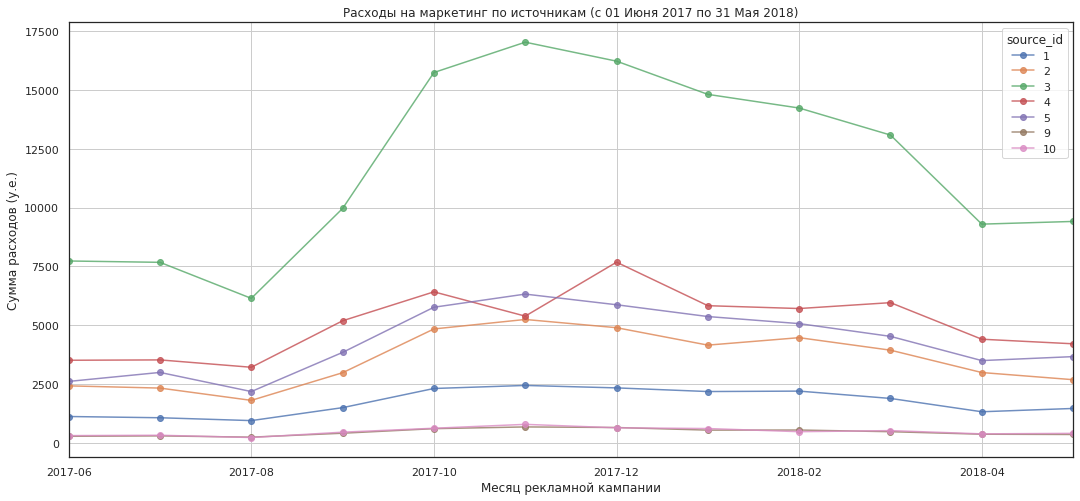

source_id,1,2,3,4,5,9,10
ad_month,,,,,,,
2017-06,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


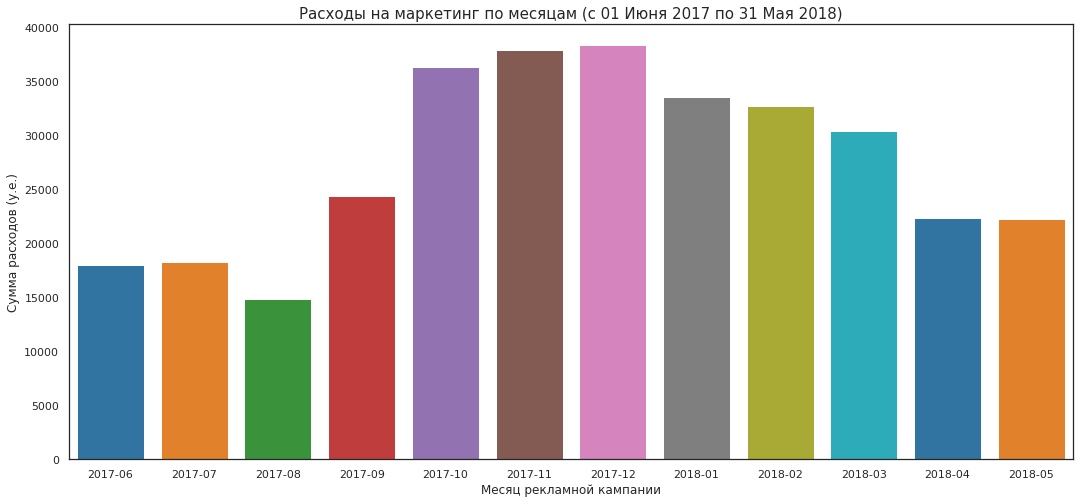

,Месяц рекламной кампании,Сумма расходов (у.е.)
0,2017-06,18015.00
1,2017-07,18240.59
2,2017-08,14790.54
3,2017-09,24368.91
4,2017-10,36322.88
5,2017-11,37907.88
6,2017-12,38315.35
7,2018-01,33518.52
8,2018-02,32723.03
9,2018-03,30415.27


Общая сумма расходов на маркетинг за 12 мес.(за период с 01 Июня 2017 по 31 Мая 2018) = 329131.6 у.е.


In [32]:
# выделим дополнительно месяц из столбца `ad_date_time`
costs['ad_month'] = costs['ad_date_time'].astype('datetime64[M]').dt.strftime('%Y-%m') 

# считаем расходы в каждом месяце по источнику `source_id`
costs_source_pivot = costs.pivot_table(index = 'ad_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')

# считаем общую сумму расходов в каждом месяце
costs_pivot = costs.pivot_table(index = 'ad_month', values = 'costs', aggfunc = 'sum').reset_index()
costs_pivot.columns = ['Месяц рекламной кампании', 'Сумма расходов (у.е.)']

# строим линейный график распределения во времени расходов по источникам
costs_source_pivot.plot(figsize = (18,8), style='o-', legend = True, grid = True, alpha = 0.8, \
title='Расходы на маркетинг по источникам (с 01 Июня 2017 по 31 Мая 2018)') \
.set(xlabel = 'Месяц рекламной кампании', ylabel = 'Сумма расходов (у.е.)')
plt.show()
display(costs_source_pivot)

# cтроим гистограмму по месяцам распределения общих расходов
plt.figure(figsize=(18,8))
sns.barplot(data=costs_pivot, x='Месяц рекламной кампании', y='Сумма расходов (у.е.)', palette="tab10")
plt.title('Расходы на маркетинг по месяцам (с 01 Июня 2017 по 31 Мая 2018)', fontsize=15)  
plt.show()
display(costs_pivot)

print('Общая сумма расходов на маркетинг за 12 мес.(за период с 01 Июня 2017 по 31 Мая 2018) = {} у.е.'.format(costs['costs'].sum().round(1)))

Явным лидером по объему расходов за год является источник под номером **3**. Его показатели маркетинговых расходов в течении года превосходят все остальные источники (более, чем в 2,5 раза судя по графику). Источники, на которые меньше тратится бюджета (в порядке возрастания трат): 10, 9, 1, 2, 5.

За год расходы по всем источникам в совокупности: месяцы Декабрь 2017, Ноябрь 2017 и Октябрь 2017 - самые "расходные" маркетинговые месяцы. И как раз именно в конце Ноября 2017 метрика DAU (п. 5.1.1.) показала самый высокий результат по кол-ву активных пользователей в день.
Любопытно, что визуально гистограмма расходов на маркетинг по месяцам прямо пропорционально соответствует по форме распределения и графика по месяцам метрики MAU.


#### CAC

**Рассчитаем CAC для каждого источника трафика и средний CAC на 1 покупателя по всем источникам в совокупности.**

In [33]:
# определим первый источник каждого пользователя: отсортируем по id-пользователя и началу сессии,
# и сгруппируем, определив первый источник с помощью оператора `first`

first_source_per_user = visits.sort_values(by = ['uid', 'session_start']).groupby('uid').agg({'source_id': 'first'}) \
.reset_index()
print('Таблица "Первые источники трафика пользователей"')
first_source_per_user.head(7)

Таблица "Первые источники трафика пользователей"


,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
5,397399764396656,4
6,407573351275847,2


In [34]:
# сгруппируем расходы по месяцу и источнику и подсчитаем их сумму

costs_per_month_and_source = costs.groupby(['ad_month', 'source_id']).agg({'costs': 'sum'}).reset_index()
costs_per_month_and_source.columns = ['month', 'source_id', 'costs_per_month_and_source']
print('Таблица "Расходы за месяц в группировке по источникам"')
costs_per_month_and_source.head(7)

Таблица "Расходы за месяц в группировке по источникам"


,month,source_id,costs_per_month_and_source
0,2017-06,1,1125.61
1,2017-06,2,2427.38
2,2017-06,3,7731.65
3,2017-06,4,3514.80
4,2017-06,5,2616.12
5,2017-06,9,285.22
6,2017-06,10,314.22


Поскольку для расчета САС нам нужен список c `'uid'` непосредственно покупателей, а не просто посетителей из таблицы `visits`, то обратимся к таблице `orders_new`, рассчитанной ранее в п.5.2.4, где уже есть месяц первого заказа `first_order_month` и `uid` покупателя.

In [35]:
# объединим `orders_new` с таблицей `first_source_per_user` по `uid`
sources_and_orders = pd.merge(orders_new, first_source_per_user, on='uid')
sources_and_orders['first_order_month'] = sources_and_orders['first_order_month'].dt.strftime('%Y-%m')

# переименуем для дальнейшего использования данного столбца в методе `.merge()`
sources_and_orders = sources_and_orders.rename({'first_order_month': 'month'}, axis = 'columns') 

# сгруппируем покупателей по первому месяцу заказа и первому источнику и найдем их количество
buyers_by_source_and_month = sources_and_orders.groupby(['month', 'source_id']).agg({'uid': 'nunique'}) \
.reset_index()
print('Таблица "Кол-во покупателей за месяц в группировке по источнику"')
buyers_by_source_and_month.head(7)

Таблица "Кол-во покупателей за месяц в группировке по источнику"


,month,source_id,uid
0,2017-06,1,190
1,2017-06,2,235
2,2017-06,3,638
3,2017-06,4,413
4,2017-06,5,384
5,2017-06,9,68
6,2017-06,10,95


In [36]:
# соединим в общую таблицу, объединяя и по месяцу и по номеру источника

total_report = pd.merge(buyers_by_source_and_month, costs_per_month_and_source, on = ['month', 'source_id'])
total_report['cac'] = (total_report['costs_per_month_and_source'] / total_report['uid']).round(2)
print('Итоговая таблица')
total_report.head(7)

Итоговая таблица


,month,source_id,uid,costs_per_month_and_source,cac
0,2017-06,1,190,1125.61,5.92
1,2017-06,2,235,2427.38,10.33
2,2017-06,3,638,7731.65,12.12
3,2017-06,4,413,3514.80,8.51
4,2017-06,5,384,2616.12,6.81
5,2017-06,9,68,285.22,4.19
6,2017-06,10,95,314.22,3.31


На основе таблицы `total_report` отобразим визуально на графиках для каждого источника трафика динамику изменения метрики CAC во времени (за период с 01 Июня 2017 по 31 Мая 2018).

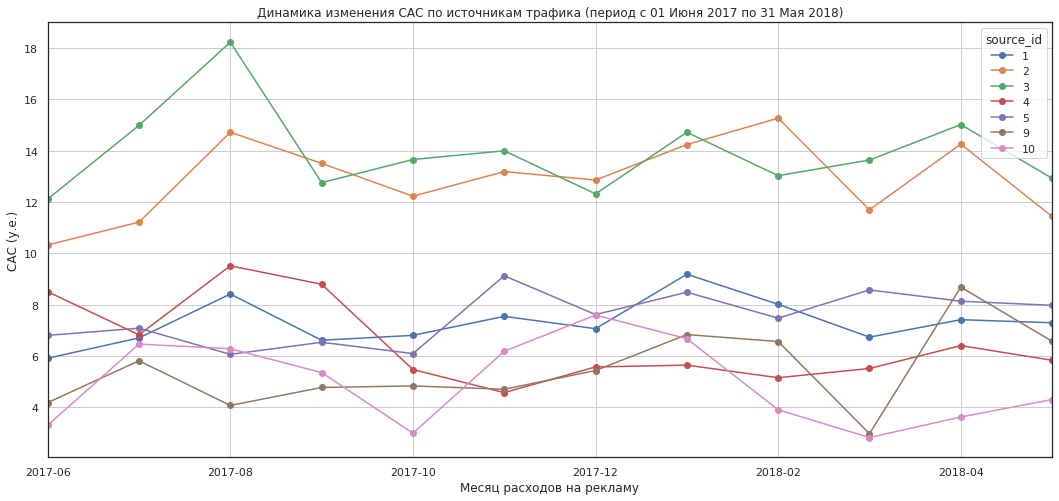

------------------------------------------------------------------------
Таблица "САС по источникам трафика (период с 01 Июня 2017 по 31 Мая 2018)"


source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06,5.92,10.33,12.12,8.51,6.81,4.19,3.31
2017-07,6.71,11.22,14.99,6.83,7.09,5.82,6.47
2017-08,8.42,14.72,18.23,9.52,6.07,4.08,6.29
2017-09,6.62,13.51,12.76,8.80,6.54,4.78,5.36
2017-10,6.81,12.23,13.66,5.48,6.10,4.84,3.00
2017-11,7.55,13.19,14.00,4.58,9.13,4.71,6.19
2017-12,7.07,12.86,12.32,5.58,7.62,5.44,7.60
2018-01,9.19,14.24,14.72,5.65,8.49,6.84,6.68
2018-02,8.02,15.27,13.03,5.16,7.48,6.57,3.91


In [37]:
cac_by_sources = total_report.pivot_table(index = 'month', columns = 'source_id', values = 'cac')

cac_by_sources.plot(grid=True, figsize=(18, 8), style='o-')
plt.xlabel('Месяц расходов на рекламу')
plt.ylabel('САС (у.е.)')
plt.title('Динамика изменения CAC по источникам трафика (период с 01 Июня 2017 по 31 Мая 2018)')
plt.show()
print('------------------------------------------------------------------------')
print('Таблица "САС по источникам трафика (период с 01 Июня 2017 по 31 Мая 2018)"')
display(cac_by_sources)

Посчитаем теперь средний САС на 1 покупателя по месяцам без разбивки по источникам.

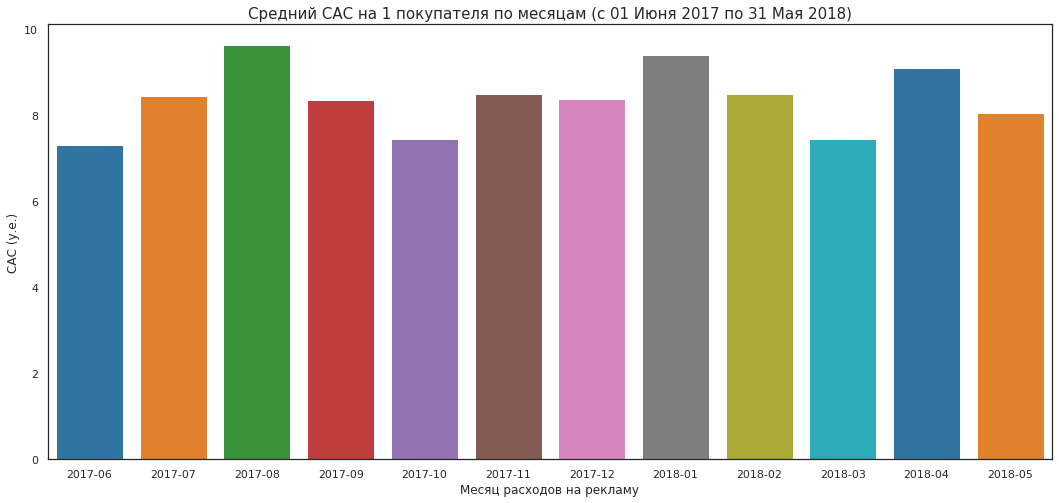

------------------------------------------------------------------------
Таблица "Средний САС на 1 покупателя (периодс 01 Июня 2017 по 31 Мая 2018)"


,Месяц расходов на рекламу,CAC (y.e.)
0,2017-06,7.31
1,2017-07,8.45
2,2017-08,9.62
3,2017-09,8.34
4,2017-10,7.45
5,2017-11,8.48
6,2017-12,8.36
7,2018-01,9.40
8,2018-02,8.49
9,2018-03,7.43


Среднегодовой САС на 1 покупателя = 8.37 у.е.


In [38]:
# группируем по месяцу и считаем среднее значение
mean_monthly_cac = total_report.groupby('month').agg({'cac': 'mean'}).round(2).reset_index()
mean_monthly_cac.columns =['Месяц расходов на рекламу', 'CAC (y.e.)']

# cтроим гистограмму по месяцам распределения общих расходов
plt.figure(figsize=(18,8))
sns.barplot(data=mean_monthly_cac, x='Месяц расходов на рекламу', y='CAC (y.e.)', palette="tab10")
plt.title('Средний САС на 1 покупателя по месяцам (с 01 Июня 2017 по 31 Мая 2018)', fontsize=15)  
plt.show()
print('------------------------------------------------------------------------')
print('Таблица "Средний САС на 1 покупателя (периодс 01 Июня 2017 по 31 Мая 2018)"')
display(mean_monthly_cac)
print('Среднегодовой САС на 1 покупателя = {} у.е.'.format(mean_monthly_cac['CAC (y.e.)'].mean().round(2)))

Метрика САС у источников 2 и 3 самая высокая.
Все остальные источники держатся визуально в одних диапазонах показателей САС по месяцам, почти вдвое меньше, чем у 2 и 3 источников.
Август 2017, Январь 2018, Апрель 2018 - месяцы с самым высоким месячным САС на 1 покупателя (без разделения по источникам трафика).

#### ROMI

**Рассчитаем ROMI по когортам для каждого источника трафика отдельно и сравним окупаемость за одинаковые периоды жизни когорт.**

Для этого сначала нам нужно рассчитать LTV по каждому из источников, соответственно. САС по источникам мы рассчитали ранее в п.5.3.2.

Создадим цикл, который будет перебирать источники и в зависимости от № источника формировать нужные срезы, на основании которых для каждого источника мы рассчитаем еще раз (как и в п. 5.2.4.) сначала LTV, затем внесём данные со столбцом САС в общую таблицу и в конце рассчитаем ROMI и построим для каждого источника тепловую карту ROMI по когортам.

В п. 5.3.2. мы уже рассчитали первые источники трафика для каждого пользователя. Они содержатся в таблице `first_source_per_user`.

In [39]:
first_source_per_user.head()

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Объединим таблицу `first_source_per_user` и `orders` в одну по `uid`.

In [40]:
orders_with_1st_sources = pd.merge(first_source_per_user, orders, on='uid')
print('Таблица "Заказы покупателей и номер первого источника перехода `source_id`"')
orders_with_1st_sources.head()

Таблица "Заказы покупателей и номер первого источника перехода `source_id`"


,uid,source_id,order_date_time,revenue,order_month
0,313578113262317,2,2018-01-03 21:51:00,0.55,2018-01-01
1,1575281904278712,10,2017-06-03 10:13:00,1.22,2017-06-01
2,1575281904278712,10,2017-06-03 17:39:00,1.83,2017-06-01
3,2429014661409475,3,2017-10-11 18:33:00,73.33,2017-10-01
4,2464366381792757,5,2018-01-28 15:54:00,2.44,2018-01-01


Создаем цикл. Предыдущие комментарии к шагам в коде (как в п.5.2.4.) дублировать не будем - ниже только новые комментарии к новым строкам кода в цикле.

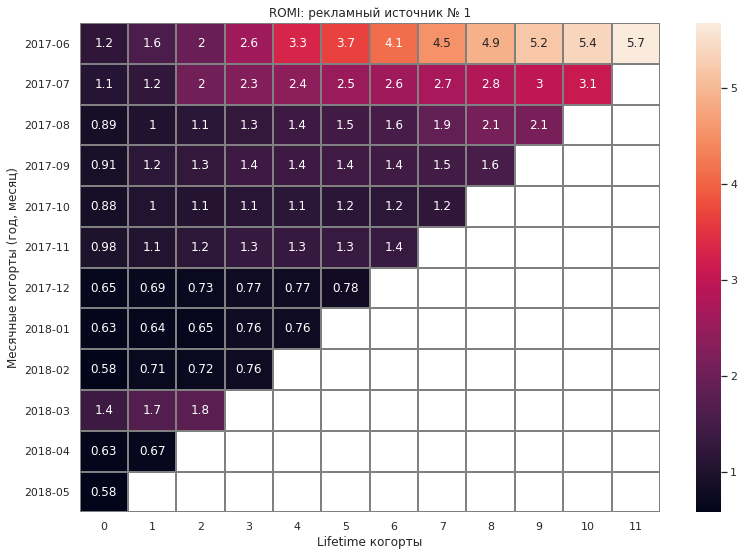

Средняя когорта (источник № 1)


age
0     0.87
1     1.05
2     1.26
3     1.36
4     1.57
5     1.77
6     2.04
7     2.36
8     2.86
9     3.44
10    4.26
11    5.68
dtype: float64

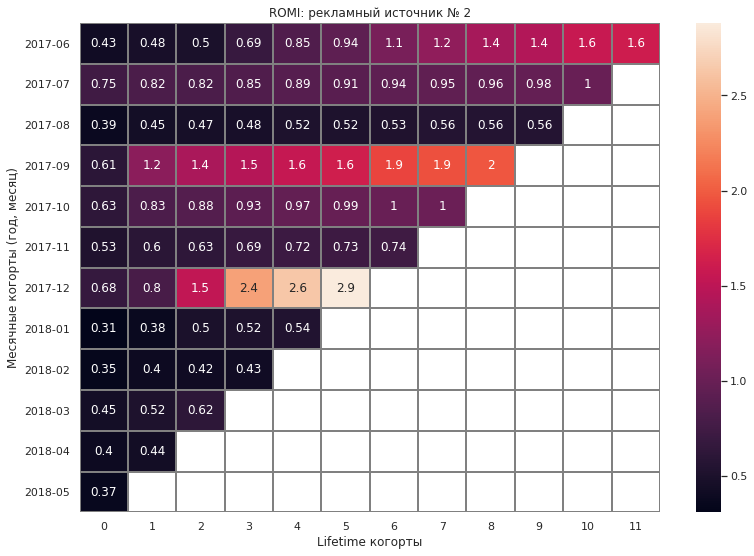

Средняя когорта (источник № 2)


age
0     0.49
1     0.63
2     0.78
3     0.94
4     1.09
5     1.23
6     1.03
7     1.14
8     1.21
9     0.99
10    1.29
11    1.61
dtype: float64

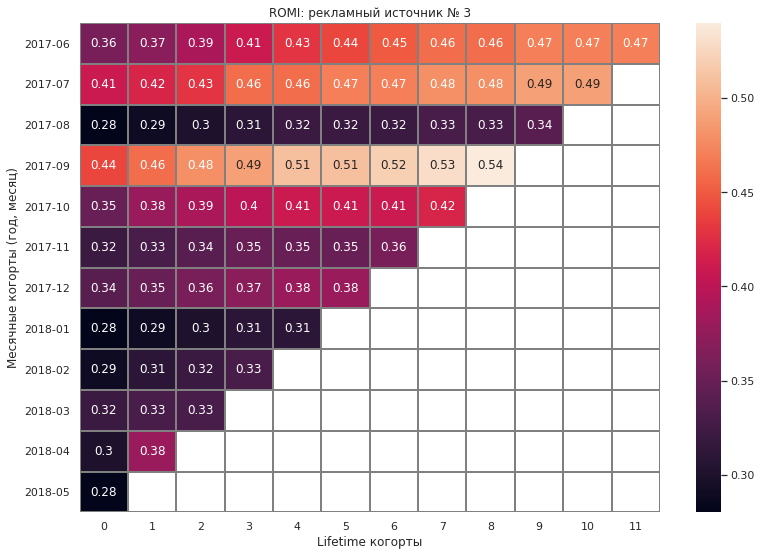

Средняя когорта (источник № 3)


age
0     0.33
1     0.36
2     0.36
3     0.38
4     0.39
5     0.41
6     0.42
7     0.44
8     0.45
9     0.43
10    0.48
11    0.47
dtype: float64

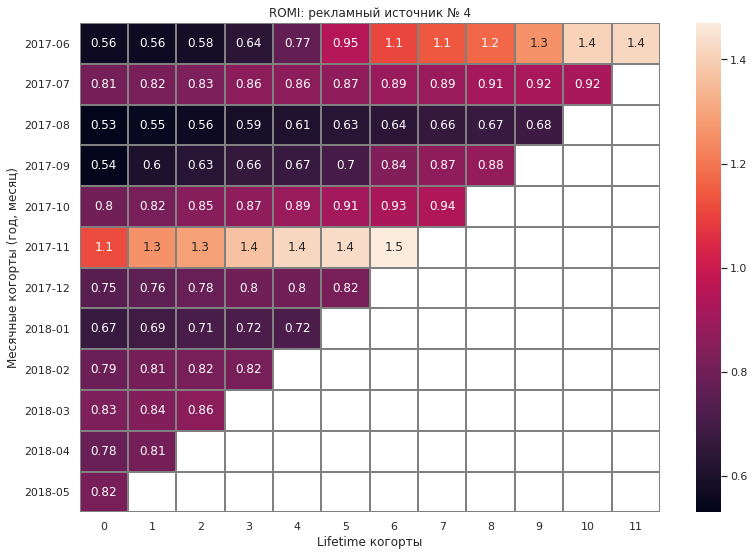

Средняя когорта (источник № 4)


age
0     0.75
1     0.78
2     0.79
3     0.81
4     0.84
5     0.90
6     0.98
7     0.90
8     0.90
9     0.95
10    1.16
11    1.42
dtype: float64

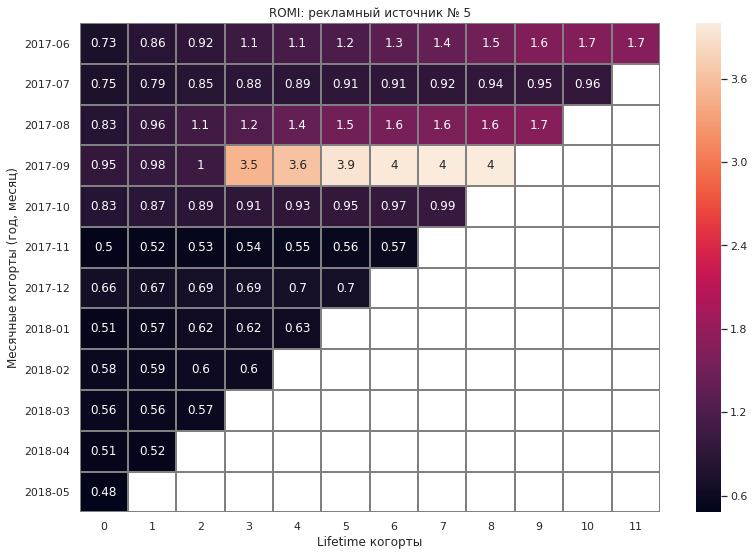

Средняя когорта (источник № 5)


age
0     0.66
1     0.72
2     0.78
3     1.11
4     1.23
5     1.39
6     1.55
7     1.78
8     2.02
9     1.42
10    1.31
11    1.67
dtype: float64

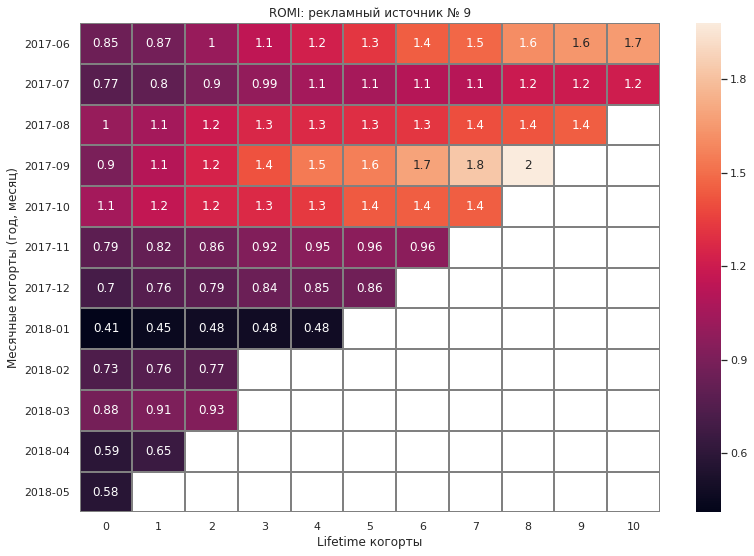

Средняя когорта (источник № 9)


age
0     0.77
1     0.85
2     0.94
3     1.04
4     1.09
5     1.21
6     1.33
7     1.46
8     1.55
9     1.43
10    1.43
dtype: float64

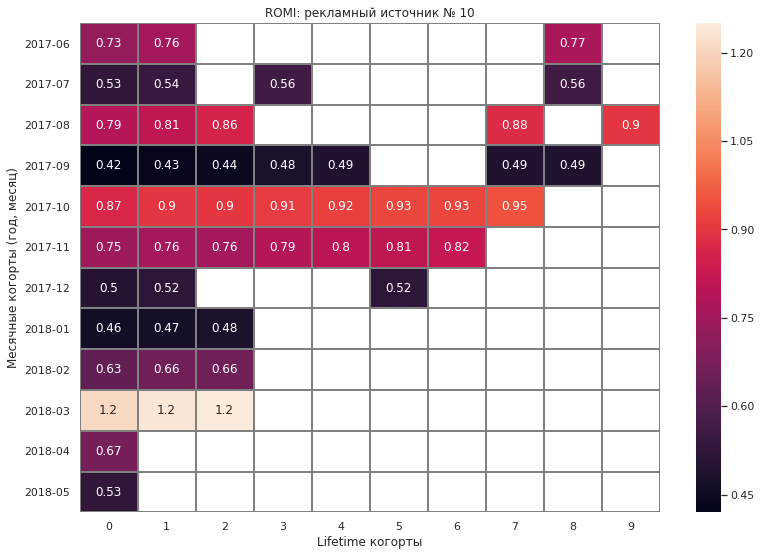

Средняя когорта (источник № 10)


age
0    0.68
1    0.71
2    0.77
3    0.68
4    0.74
5    0.75
6    0.88
7    0.77
8    0.61
9    0.90
dtype: float64

In [41]:
for i in costs['source_id'].unique().tolist():
    
    # в `filtered_orders_by_source` помещаем срез по источнику i на основании объединённой таблицы `orders_with_1st_sources`
    filtered_orders_by_source = orders_with_1st_sources.query('source_id == @i')
    
    first_orders_final = filtered_orders_by_source.groupby('uid').agg({'order_month': 'min'}).reset_index()
    first_orders_final.columns = ['uid', 'first_order_month']
    
    cohort_sizes_final = first_orders_final.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes_final.columns = ['first_order_month', 'n_buyers']

    orders_new_final = pd.merge(filtered_orders_by_source, first_orders_final, on='uid')
    cohorts_final = orders_new_final.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
    
    report_final = pd.merge(cohort_sizes_final, cohorts_final, on='first_order_month')
    report_final['gross_profit'] = report_final['revenue'].copy()
    report_final['age'] = (report_final['order_month'] - report_final['first_order_month']) / np.timedelta64(1, 'M')
    report_final['age'] = report_final['age'].round().astype('int')
    report_final['ltv'] = report_final['gross_profit'] / report_final['n_buyers']
    report_final['first_order_month'] = report_final['first_order_month'].dt.strftime('%Y-%m')

    # таблица`total_report` содержит столбец с САС, нужный нам для расчета ROMI
    # присоединим `total_report` к `report_final` по первому месяцу заказа `first_order_month`
    
    # предварительно сделаем срез по нужному источнику, чтобы корректно отфильтровать CAC по месяцу
    total_report_by_source = total_report.query('source_id == @i')
    # и переименуем для объединения название столбца в 'first_order_month'
    total_report_by_source = total_report_by_source.rename({'month': 'first_order_month'}, axis = 'columns')
    # объединяем, чтобы получить доступ к столбцу с САС
    final_metrics = pd.merge(report_final, total_report_by_source, on = ['first_order_month'])
    
    # считаем ROMI
    final_metrics['romi'] = final_metrics['ltv'] / final_metrics['cac']

    # строим сводную таблицу 
    romi_pivot = final_metrics.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
    romi = romi_pivot.cumsum(axis=1).round(2)
    romi.fillna('') 

    # и тепловую карту
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('ROMI: рекламный источник № {}'.format(i))
    sns.heatmap(romi, annot=True, linewidths=1, linecolor='gray')
    plt.ylabel('Месячные когорты (год, месяц)')
    plt.xlabel('Lifetime когорты')
    plt.show()
    
    # определим как быстро в среднем когорты окупаются (в разбивке по источникам)
    print('Средняя когорта (источник № {})'.format(i))
    display(romi_pivot.cumsum(axis=1).mean(axis=0).round(2))

Источник № 1: окупаемость к концу 2 месяца. Самая перспективная когорта - 2017-06. На 2-ом месте когорта 2017-07.

Источник № 2: окупаемость к концу 5 месяца. Самая перспективная когорта - 2017-12, а также 2017-09.

Источник № 3: окупаемость не определена. Когорты с перспективой на рост окупаемости - 2017-09, 2017-06, 2017-07.

Источник № 4: окупаемость к концу 11 месяца. Самая перспективная когорта - 2017-11.

Источник № 5: окупаемость к концу 4 месяца. Самая перспективная когорта - 2017-09.

Источник № 9: окупаемость к концу 4 месяца. Самая перспективная когорта - 2017-09. 

Источник № 10: окупаемость не определена. Не хватает данных, или источник трафика не бюджетируется.

#### Вывод

<div style="border:solid black 2px; padding: 20px">

<b>На основании произведенных расчетов маркетинговых метрик обнаружено следующее:</b><br><br>

1) Явным лидером по объему расходов за год является источник под номером 3 (более, чем в 2,5 превосходит остальные источники по затратам). Источники, на которые меньше всего расходуется маркетинговых средств (в порядке возрастания трат): 10, 9, 1, 2, 5.<br>

2) В совокупности по всем источникам: Декабрь, Ноябрь и Октябрь 2017 самые "расходные" маркетинговые месяцы.<br>
    
3) Гистограмма расходов на маркетинг по месяцам по пиковым точкам визуально прямо пропорционально соответствует графику по месяцам метрики MAU.<br>
 
4) Метрика САС у источников 2 и 3 самая высокая. Все остальные источники держатся в одних диапазонах показателей САС по месяцам.<br>
    
</div>

## Общий вывод

<div style="border: ridge black 3px; padding: 25px">
    
<b> По результатам проведенного исследования анализа бизнес-показателей сервиса "Яндекс.Афиша" определено следующее:</b><br><br>
    
наиболее <b>перспективными источниками</b> рекламного трафика являются <b>источники под №  1, 2, 5.</b> Это источники, на которые сейчас тратится меньше всего средств, но которые показывают хорошие показатели окупаемости ROMI.<br><br>
    
- Источник № 1: окупаемость к концу 2 месяца. Самая перспективная когорта клиентов - 2017-06. На 2-ом месте когорта 2017-07.<br>
- Источник № 2: окупаемость к концу 5 месяца. Самая перспективная когорта клиентов - 2017-12.<br>
- Источник № 5: окупаемость к концу 4 месяца. Самая перспективная когорта клиентов - 2017-09.<br><br>
    
От источника под № 3 стоит отказаться и перераспределить бюджетирование между остальными источниками, т.к. окупаемость маркетинговых расходов не обнаружена за исследуемый период, при этом расходы на источник № 3 почти в 2,5 раза превосходят расходы на другие источники трафика.<br>
</div>